In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, count, col, desc, min, max
from pyspark.sql.functions import col, avg, count, from_unixtime, to_date


In [0]:
spark = SparkSession.builder.appName("Movie Analytics").getOrCreate()


In [0]:
ratings_path = '/FileStore/tables/ratings.csv'
movies_path = '/FileStore/tables/movies.csv'

# Load ratings
ratings_df = spark.read.option("header", "true").csv(ratings_path)
# Load movies
movies_df = spark.read.option("header", "true").csv(movies_path)

# Show few rows to confirm
ratings_df.show(5)
movies_df.show(5)


+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|944249077|
|     1|     25|   1.0|944250228|
|     1|     29|   2.0|943230976|
|     1|     30|   5.0|944249077|
|     1|     32|   5.0|943228858|
+------+-------+------+---------+
only showing top 5 rows

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [0]:
# Convert to RDD
ratings_rdd = ratings_df.select("movieId", "rating").rdd

# Map (movieId, (rating, 1))
movie_ratings = ratings_rdd.map(lambda row: (row['movieId'], (float(row['rating']), 1)))

# Reduce (sum ratings and counts)
ratings_sum_count = movie_ratings.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))

# Compute averages
average_ratings = ratings_sum_count.mapValues(lambda x: x[0]/x[1])

# Find movie with the lowest average rating
lowest_rated_movie = average_ratings.takeOrdered(1, key=lambda x: x[1])

print("Lowest Average Rated Movie:", lowest_rated_movie)

# Map movieId -> title to get movie name
movies_map = movies_df.select("movieId", "title").rdd.collectAsMap()

for movie_id, avg_rating in lowest_rated_movie:
    print(f"Movie: {movies_map[movie_id]}, Average Rating: {avg_rating}")


Lowest Average Rated Movie: [('245662', 0.5)]
Movie: Dickshark (2016), Average Rating: 0.5


In [0]:
# Group by userId and count number of ratings
top_users = ratings_df.groupBy("userId").agg(count("movieId").alias("movie_count")).orderBy(desc("movie_count"))

top_users.show(5)


+------+-----------+
|userId|movie_count|
+------+-----------+
|175325|      33332|
| 17035|       9577|
| 55653|       9178|
|123465|       9044|
|171795|       9016|
+------+-----------+
only showing top 5 rows



+----------+-----+
|      date|count|
+----------+-----+
|1995-01-09|    4|
|1996-01-29|   42|
|1996-02-01|   59|
|1996-02-02|   67|
|1996-02-05|   32|
|1996-02-06|    1|
|1996-02-07|    1|
|1996-02-08|    4|
|1996-02-09|   10|
|1996-02-10|    1|
+----------+-----+
only showing top 10 rows



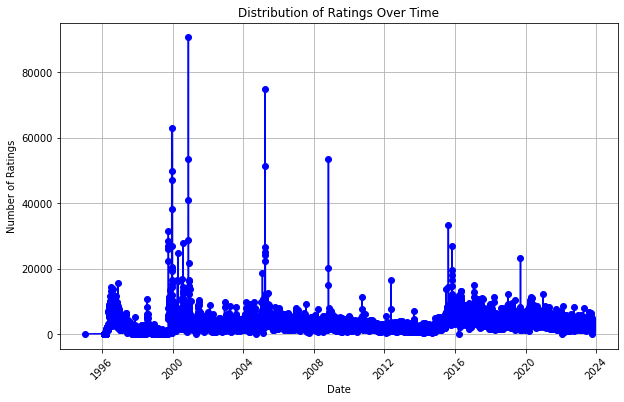

In [0]:
# Convert timestamp to date
ratings_with_date = ratings_df.withColumn("date", to_date(from_unixtime(col("timestamp"))))

# Group by date and count
rating_distribution = ratings_with_date.groupBy("date").count().orderBy("date")

rating_distribution.show(10)

# (OPTIONAL) Plotting if you want to visualize later
# Convert Spark DataFrame to Pandas DataFrame for plotting
rating_distribution_pd = rating_distribution.toPandas()

# Plot using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(rating_distribution_pd['date'], rating_distribution_pd['count'], marker='o', linestyle='-', color='b')
plt.title('Distribution of Ratings Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()


In [0]:
# Set minimum ratings threshold
min_ratings = 50

# Compute average rating + count per movie
movie_stats = ratings_df.groupBy("movieId").agg(
    avg("rating").alias("avg_rating"),
    count("rating").alias("rating_count")
)

# Filter movies with at least `min_ratings`
popular_movies = movie_stats.filter(col("rating_count") >= min_ratings)

# Order by highest average rating
best_movies = popular_movies.orderBy(desc("avg_rating"))

# Join with movies_df to get movie titles
best_movies_with_names = best_movies.join(movies_df, "movieId")

best_movies_with_names.select("title", "avg_rating", "rating_count").show(10)


+--------------------+------------------+------------+
|               title|        avg_rating|rating_count|
+--------------------+------------------+------------+
|      Platoon (1986)| 3.905312940229422|       19876|
| Pulp Fiction (1994)| 4.196968773181315|       98409|
|Fast Times at Rid...|3.6545741324921135|        9510|
|         Antz (1998)|3.2133857042856033|       12857|
|Captain America: ...|3.4727476176725385|       13852|
|Alice Through the...|3.0217391304347827|        1357|
|Last King of Scot...|3.8391304347826085|        7130|
|   Ex Machina (2015)| 3.988002720031086|       20588|
|Joe's Apartment (...|2.6587506453278267|        1937|
|       Popeye (1980)| 2.566042780748663|        3740|
+--------------------+------------------+------------+
only showing top 10 rows

